# Data loader

Code reference: 
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

Dataset reference:
https://github.com/YoongiKim/CIFAR-10-images

 - Dataset information:
Cifar-10 dataset | Airplane |Automobile|Bird|Cat|Deer|Dog|Frog|Horse|Ship|Truck||||||||||||||||||||||||||||||
--||||||||||||||||||||||||||||||||||||||||
Train number |5000|5000|5000|5000|5000|5000|5000|5000|5000|5000||||||||||||||||||||||||||||||
Test number  |1000|1000|1000|1000|1000|1000|1000|1000|1000|1000||||||||||||||||||||||||||||||
Image format |jpg|||||||||||||||||||||||||||||||||||||||

---

####  Load package

In [1]:
import os
import cv2
import glob
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import torch.nn.functional as F
from skimage import io
import numpy as np
import matplotlib.pyplot as plt

#### Basic information

In [2]:
train_folder = './dataset/CIFAR_10/train/' 
test_folder  = './dataset/CIFAR_10/test/'

#### Build the data loader

In [3]:
class LoadClassificationDataset(Dataset):
    """input: image, output: one-hot code"""

    def __init__(self, img_folder, transform=None):

        self.transform  = transform
        if not img_folder.endswith('/'):
            img_folder += ('/')
            
        self.img_paths    = glob.glob(img_folder+'*/*')
        self.img_classes  = os.listdir(img_folder)
        self.class_number = len(self.img_classes)
        self.label_dict   = dict(zip(self.img_classes, [i for i in range(self.class_number)]))
        
    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_path  = self.img_paths[idx]
        img       = io.imread(img_path)
        
        # in windows: '\\'   ,   in linux:'/'
        img_class = img_path.split('\\')[-2]
        img_label = self.label_dict[img_class]
        one_hot_label = F.one_hot(torch.tensor(img_label), num_classes=self.class_number)
        
        output = {'image': img, 'label': one_hot_label}

        if self.transform:
            output = self.transform(output)

        return output
    
    def get_data_label(self, idx):
        
        img_path  = self.img_paths[idx]
        # in windows: '\\'   ,   in linux:'/'
        img_class = img_path.split('\\')[-2]
        return img_class
    
    def one_hot_to_label_dict(self):
        
        class_number_list = [i for i in range(self.class_number)]
        class_one_hot_list = [str(F.one_hot(torch.tensor(i), num_classes=self.class_number).tolist()) for i in class_number_list]
        
        return dict(zip(class_one_hot_list, self.img_classes))

#### Create testing dataset

In [4]:
test_dataset = LoadClassificationDataset(test_folder)
print(test_dataset.img_classes)
print(test_dataset.label_dict)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


#### Dataset Visualization

image  1  dog          [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
image  2  dog          [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
image  3  dog          [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
image  4  dog          [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
image  5  dog          [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
image  6  dog          [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
image  7  dog          [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
image  8  dog          [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
image  9  dog          [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
image 10  dog          [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
image 11  dog          [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
image 12  dog          [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
image 13  dog          [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
image 14  dog          [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
image 15  dog          [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
image 16  dog          [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


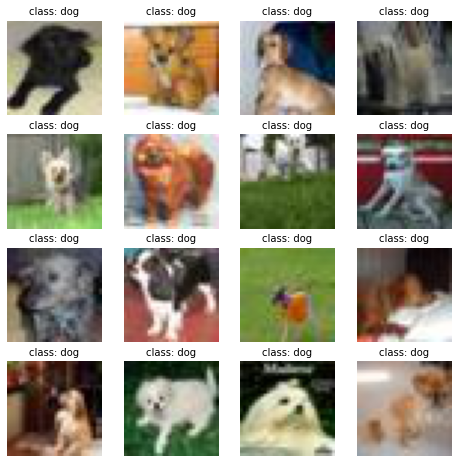

In [5]:
plot = plt.figure(figsize=(8,8))
imgs = []
img_classes = []
# 16: random shows 16 images
for i in range(16):
    idx = i+1
    number = np.random.randint(1, len(test_dataset))
    data_pair = test_dataset[number]
    img, onehot_label = data_pair['image'], data_pair['label']
    
    img_class = test_dataset.get_data_label(number)
    print('image %2d  %-10s   %s'%(idx, img_class, onehot_label.tolist()))
    
    # 4 x 4 = 16
    plt.subplot(4,4,idx)
    plt.title(f'class: {img_class}', fontsize=10)
    plt.axis('off')
    plt.imshow(img)
    imgs.append(img)
    img_classes.append(img_class)

# Augmentation

#### Define 2 augmentation  methods: Rescale and Rotate

In [6]:
class Rescale():

    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, img_label_pair):
        img, label = img_label_pair['image'], img_label_pair['label']
        
        if len(img.shape) < 3:
            img = np.reshape(img, (img.shape[0], img.shape[1], 1))
        
        h, w          = img.shape[:2]
        channel       = img.shape[-1]
        scale         = min(self.output_size/w, self.output_size/h)
        new_h, new_w  = int(scale*h), int(scale*w)
        image_resized = cv2.resize(img, (new_w, new_h))
        pad_h, pad_w  = (self.output_size-new_h) // 2, (self.output_size-new_w) // 2
        
        image_paded   = np.full(shape=[self.output_size, self.output_size, channel], fill_value=0)
        image_paded[pad_h:new_h+pad_h, pad_w:new_w+pad_w, :] = image_resized
        image_paded   = np.array(image_paded, np.uint8)
        
        return {'image': image_paded, 'label': label}

In [7]:
class Rotate():

    def __init__(self, angle_max):
        self.angle_max = angle_max

    def __call__(self, img_label_pair):
        img, label = img_label_pair['image'], img_label_pair['label']
        
        if len(img.shape) < 3:
            img = np.reshape(img, (img.shape[0], img.shape[1], 1))
        
        h, w          = img.shape[:2]
        random_angle  = np.random.randint(0, self.angle_max) 
        center = (h//2, w//2)
        M = cv2.getRotationMatrix2D(center=center, angle=random_angle, scale=1)
        
        rotate_img = cv2.warpAffine(img, M, (w, h))
        
        return {'image': rotate_img, 'label': label}

#### Augmentation visualization

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])


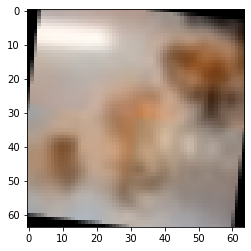

In [8]:
img_label_pair = Rescale(64)(data_pair)
img_label_pair = Rotate(360)(img_label_pair)
print(img_label_pair['label'])
plt.imshow(img_label_pair['image'])

#### Convert ndarrays to Tensors.

In [9]:
class ToTensor():

    def __call__(self, img_label_pair):
        img, label = img_label_pair['image'], img_label_pair['label']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        img = img.transpose((2, 0, 1))
        # reference of why channel first: https://pytorch.org/blog/tensor-memory-format-matters/
        return {'image': torch.from_numpy(img), 'label': label}

#### Build the training augmented dataset

In [10]:
transformed_dataset = LoadClassificationDataset(img_folder=train_folder, 
                                                transform=transforms.Compose([
                                                    Rescale(28),
                                                    Rotate(360),
                                                    ToTensor()
                                                ]))

one_hot_to_label_dict = transformed_dataset.one_hot_to_label_dict()
print(one_hot_to_label_dict)

{'[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]': 'airplane', '[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]': 'automobile', '[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]': 'bird', '[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]': 'cat', '[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]': 'deer', '[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]': 'dog', '[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]': 'frog', '[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]': 'horse', '[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]': 'ship', '[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]': 'truck'}


In [11]:
for i in range(len(transformed_dataset)):
    img_label_pair = transformed_dataset[i]

    print(i, img_label_pair['image'].size(), img_label_pair['label'].size())

    if i == 2:
        break

0 torch.Size([3, 28, 28]) torch.Size([10])
1 torch.Size([3, 28, 28]) torch.Size([10])
2 torch.Size([3, 28, 28]) torch.Size([10])


## Batch data loader for training

In [12]:
class build_dataset():
    
    def __init__(self, output_size, batch_size):
        self.output_size = output_size
        self.batch_size = batch_size
        
        
    def train(self, train_folder, rotate_range):
        
        train_dataset = LoadClassificationDataset(img_folder=train_folder, 
                                                  transform=transforms.Compose([
                                                      Rescale(self.output_size),
                                                      Rotate(rotate_range),
                                                      ToTensor()
                                                  ]))
        
        data_loader = DataLoader(train_dataset, 
                                 batch_size=self.batch_size,
                                 shuffle=True, 
                                 num_workers=0)
        
        return data_loader
    
    
    def test(self, test_folder):
        
        test_dataset = LoadClassificationDataset(img_folder=test_folder,
                                                 transform=transforms.Compose([
                                                     Rescale(self.output_size),
                                                     ToTensor()
                                                 ]))
        
        data_loader = DataLoader(test_dataset, 
                                 batch_size=1,
                                 shuffle=False, 
                                 num_workers=0)
        
        return data_loader
    
# reference of num_workers: https://blog.csdn.net/qq_24407657/article/details/103992170

In [13]:
build_data_loader = build_dataset(output_size=36, batch_size=8)
dataloader = build_data_loader.train(train_folder, 360)

In [14]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['label'].size())

    if i_batch == 2:
        break

0 torch.Size([8, 3, 36, 36]) torch.Size([8, 10])
1 torch.Size([8, 3, 36, 36]) torch.Size([8, 10])
2 torch.Size([8, 3, 36, 36]) torch.Size([8, 10])


#### Results visualization

In [15]:
def show_batch_imgs(sample_batched, one_hot_to_label_dict=one_hot_to_label_dict):
    
    images_batch, label_batch = sample_batched['image'], sample_batched['label']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2
    grid = utils.make_grid(images_batch)
    
    title=''
    for i in range(batch_size):
        title += (f'{i+1}   '+str(one_hot_to_label_dict[str(label_batch[i].tolist())])+'\n')
    
    plt.figure(figsize=(15,3))
    plt.title(title, loc='left', fontsize=16)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

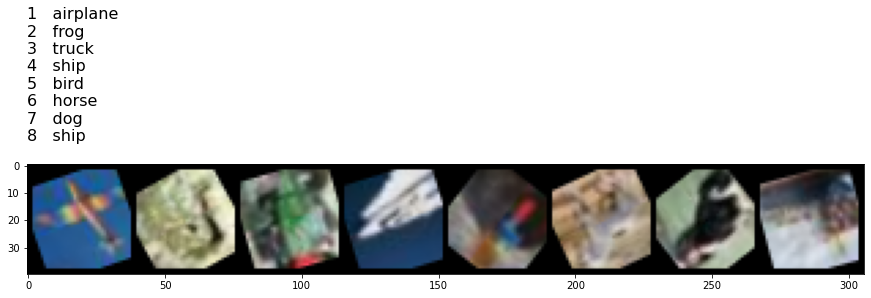

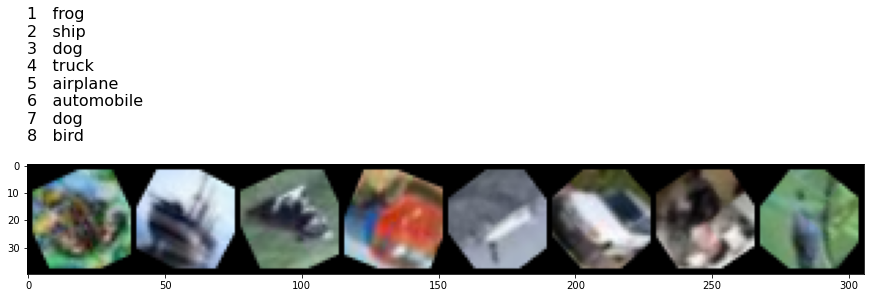

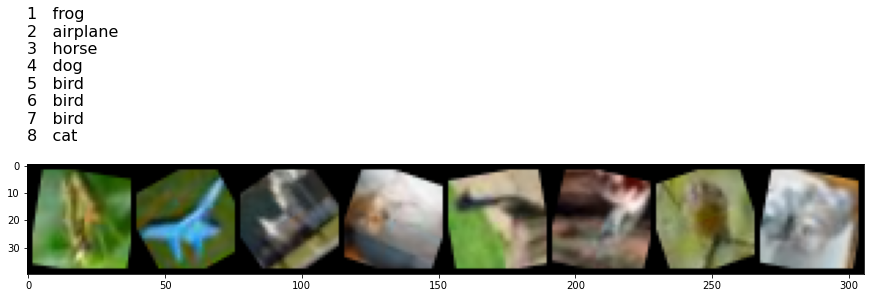

In [16]:
for i_batch, sample_batched in enumerate(dataloader):
    show_batch_imgs(sample_batched)
    if i_batch == 2:
        break